[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AlexAndorra/advanced-gp-pydata/blob/master/notebooks/gaussian_processes.ipynb)

# Mastering Gaussian Processes with PyMC

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.cm as cmap
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns

sns.set_context("notebook")

RANDOM_SEED = 42
DATA_URL = (
    "https://raw.githubusercontent.com/AlexAndorra/advanced-gp-pydata/master/data/"
)

## Introduction

Most of us are familiar with linear regression models, which are a type of *parametric* model. In a linear regression model, we assume that the relationship between the input variables $x$ and the output variable $y$ is linear, and we model the relationship using a linear combination of the input variables.

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \epsilon$$

where $\beta_0, \beta_1, \ldots, \beta_p$ are the model parameters and $\epsilon$ is the error term. The model parameters specify a line in the $p$-dimensional space of input variables, and the error term allows for the data to deviate from the linear prediction. Even if we have data that describe non-linear relationships, we can often use a model that is linear in its parameters by expanding the space of input variables using basis functions.

$$y = \beta_0 + \beta_1 \phi_1(x_1) + \beta_2 \phi_2(x_2) + \cdots + \beta_p \phi_p(x_p) + \epsilon$$

where $\phi_1(x_1), \phi_2(x_2), \ldots, \phi_p(x_p)$ are the basis functions. The simplest example of this is polynomial regression, where the basis functions are powers of the input variable:

$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \cdots + \beta_p x^p + \epsilon$$

The limitation of parametric, linear models is that decisions about the form of the relationship between $x$ and $y$ must be made *before* the data have been observed. We can only ever hope to approximate the true relationship, and the quality of the approximation will depend on the choices we made about the form of the relationship.

An alternative to parametric models are *non-parametric* models, which do not make any assumptions about the form of the relationship between $x$ and $y$. Instead, we can use a Gaussian process to model an arbitrary smooth, continuous relationship between $x$ and $y$. Rather than modeling parameters associated with a latent function, these methods predict the function directly.


## Gaussian Processes

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the first and fundamental step in Bayesian modeling is to specify a *full probability model* for the problem at hand. It is rather difficult to explicitly state a full probability model without the use of probability functions, which are parametric. Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

### Building models with Gaussians

What if we chose to use Gaussian distributions to model our data? 

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a *function*. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a **mean function** and a **covariance function**:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. 

In [2]:
def exponential_cov(x, y, scale, length_scale):
    return scale * np.exp(-0.5 * length_scale * np.subtract.outer(x, y) ** 2)

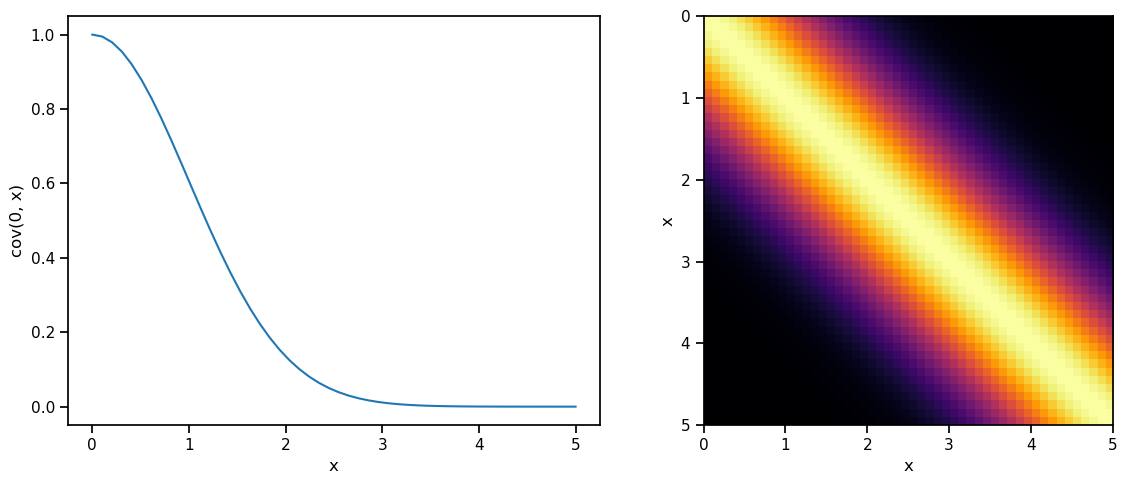

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
xrange = np.linspace(0, 5)
ax1.plot(xrange, exponential_cov(0, xrange, 1, 1))
ax1.set_xlabel("x")
ax1.set_ylabel("cov(0, x)")

z = np.array([exponential_cov(xrange, xprime, 1, 1) for xprime in xrange])
ax2.imshow(z, cmap="inferno", interpolation="none", extent=(0, 5, 5, 0))
ax2.set_xlabel("x")
ax2.set_ylabel("x")

plt.tight_layout();

It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

## Sampling from a Gaussian Process Prior

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which result in an evaluation of a function over a set of points. All we will do here is sample from the *prior* Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

We are going generate realizations sequentially, point by point, using the lovely conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(y^*| x^*, y, x) = \mathcal{N}(\Sigma_{x^*x}\Sigma_y^{-1}y,\>
\Sigma_{x^*}-\Sigma_{x^*x}\Sigma_y^{-1}\Sigma_{x^*x}^T)$$

And this the function that implements it:

In [4]:
def conditional(x_new, x, y, scale, length_scale):
    B = exponential_cov(x_new, x, scale, length_scale)
    C = exponential_cov(x, x, scale, length_scale)
    A = exponential_cov(x_new, x_new, scale, length_scale)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return (mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

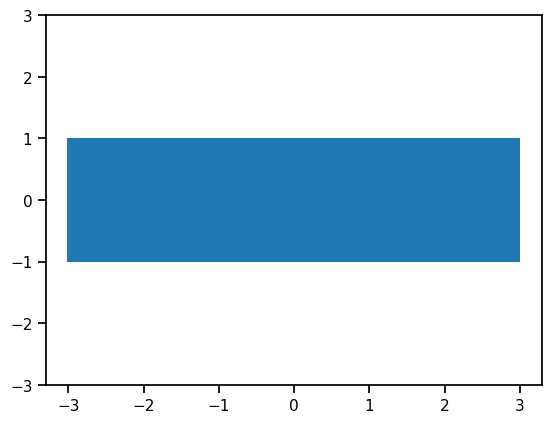

In [5]:
scale, length_scale = 1, 10
sigma_0 = exponential_cov(0, 0, scale, length_scale)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)
plt.ylim(-3, 3);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [6]:
x = [1.0]
y = [np.random.normal(scale=sigma_0)]
y

[-0.5136768971249756]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$. 

In [7]:
sigma_1 = exponential_cov(x, x, scale, length_scale)

In [8]:
def predict(x, data, kernel, scale, length_scale, sigma, t):
    k = [kernel(x, y, scale, length_scale) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, scale, length_scale) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [9]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [
    predict(i, x, exponential_cov, scale, length_scale, sigma_1, y) for i in x_pred
]

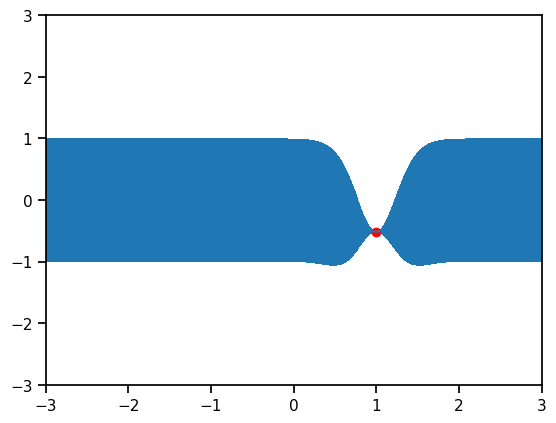

In [10]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3)
plt.ylim(-3, 3);

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [11]:
m, s = conditional([-0.7], x, y, scale, length_scale)
y2 = np.random.normal(m, s)
y2

-0.6171648283410321

This point is added to the realization, and can be used to further update the location of the next point.

In [12]:
x.append(-0.7)
y.append(y2)

In [13]:
sigma_2 = exponential_cov(x, x, scale, length_scale)

predictions = [
    predict(i, x, exponential_cov, scale, length_scale, sigma_2, y) for i in x_pred
]

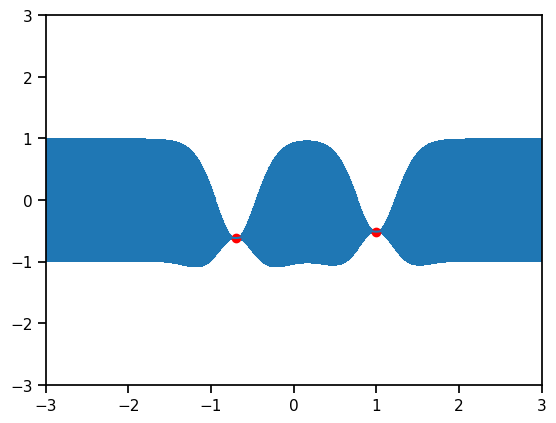

In [14]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3)
plt.ylim(-3, 3);

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [15]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, scale, length_scale)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-0.29641584,  0.02188026,  1.25778232, -0.70105099,  0.01411502])

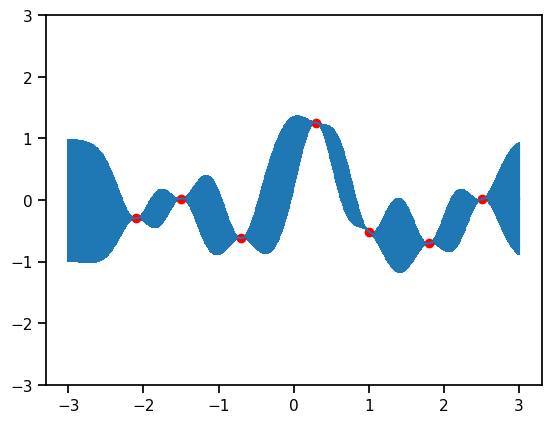

In [16]:
x += x_more
y += y_more.tolist()

sigma_new = exponential_cov(x, x, scale, length_scale)

predictions = [
    predict(i, x, exponential_cov, scale, length_scale, sigma_new, y) for i in x_pred
]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

So as the density of points becomes high, the result will be one realization (function) from the prior GP. 

## Gaussian processes regression

The following simulated data clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

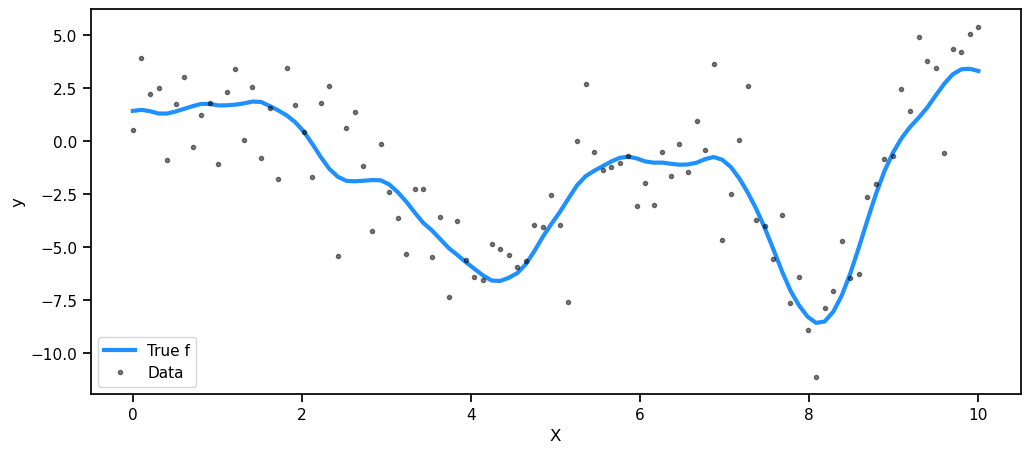

In [17]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
x = np.linspace(0, 10, n)
X = x[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, l_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of PyTensor
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

## Marginal Likelihood Implementation

The `gp.Marginal` class in PyMC implements the simplest case of GP regression:  the observed data are the sum of a GP and Gaussian noise.  `gp.Marginal` has a `marginal_likelihood` method, a `conditional` method, and a `predict` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

The observations $y$ are the unknown function plus noise

$$
\begin{aligned}
  \epsilon &\sim N(0, \Sigma) \\
  y &= f(x) + \epsilon \\
\end{aligned}
$$

### The Marginal Likelihood

The marginal likelihood is the normalizing constant for the posterior distribution, and is the integral of the product of the likelihood and prior.

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$

where for Gaussian processes, we are marginalizing over function values $f$ (instead of parameters $\theta$).

**GP prior**:

$$\log p(f|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K| -\frac{1}{2}f^TK^{-1}f $$

**Gaussian likelihood**:

$$\log p(y|f,X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|\sigma^2I| -\frac{1}{2}(y-f)^T(\sigma^2I)^{-1}(y-f) $$

**Marginal likelihood**:

$$\log p(y|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

Notice that the marginal likelihood includes both a data fit term $- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y$ and a parameter penalty term $\frac{1}{2}\log|K + \sigma^2I|$. Hence, the marginal likelihood can help us select an appropriate covariance function, based on its fit to the dataset at hand.

### Choosing parameters

This is relevant because we have to make choices regarding the parameters of our Gaussian process; they were chosen arbitrarily for the random functions we demonstrated above.

For example, in the squared exponential covariance function, we must choose two parameters:

$$k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)$$

The first parameter $\theta_1$ is a scale parameter, which allows the function to yield values outside of the unit interval. The second parameter $\theta_2$ is a length scale parameter that determines the degree of covariance between $x$ and $x^{\prime}$; smaller values will tend to smooth the function relative to larger values.

We can use the **marginal likelihood** to select appropriate values for these parameters, since it trades off model fit with model complexity. Thus, an optimization procedure can be used to select values for $\theta$ that maximize the marginial likelihood.

### Covariance functions

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

PyMC includes a library of covariance functions to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

To provide an idea regarding the variety of forms or covariance functions, here's small selection of available ones:

In [18]:
X_grid = np.linspace(0, 2, 200)[:, None]


# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8 * np.eye(X.shape[0])
    x = X.flatten()

    with sns.axes_style("white"):
        fig = plt.figure(figsize=(14, 5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(
            K,
            cmap="inferno",
            interpolation="none",
            extent=(np.min(X), np.max(X), np.max(X), np.min(X)),
        )
        plt.colorbar(m)
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:, 0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14, 4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T
        for i in range(samples.shape[1]):
            ax.plot(x, samples[:, i], color=cmap.inferno(i * 0.2), lw=2)
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

### Quadratic exponential covariance

This is the squared exponential covariance function.

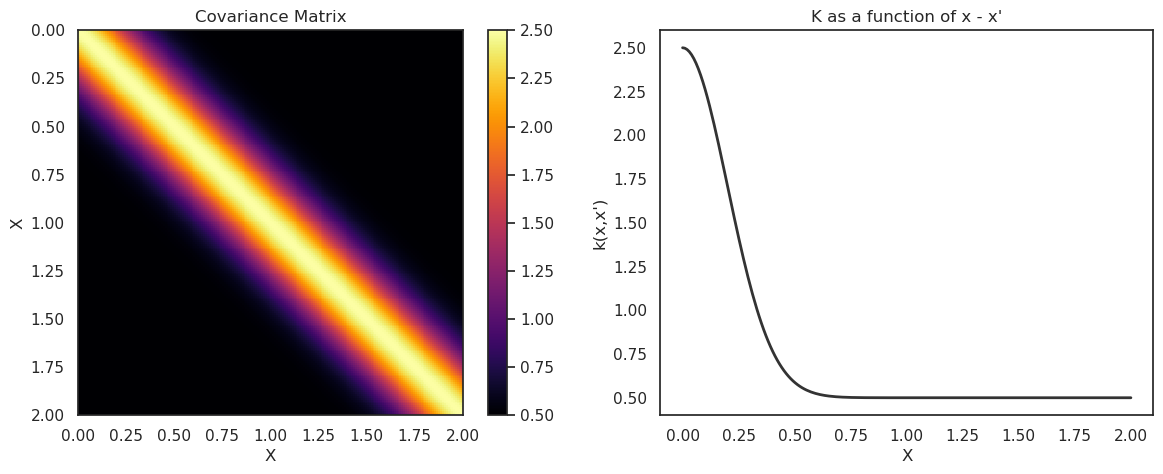

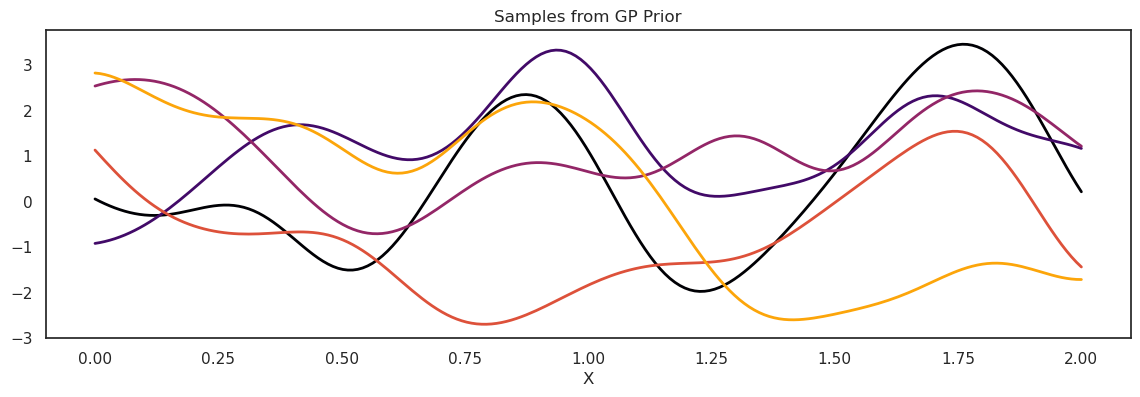

In [19]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    b = 0.5
    cov = b + tau * pm.gp.cov.ExpQuad(1, l)

K = pytensor.function([], cov(X_grid))()

plot_cov(X_grid, K)

### Matern $\nu=3/2$ covariance

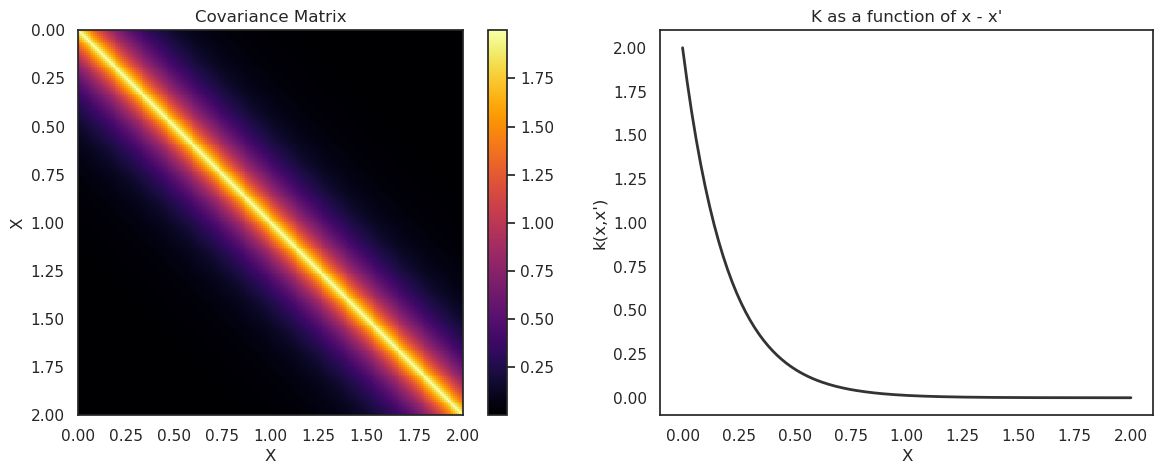

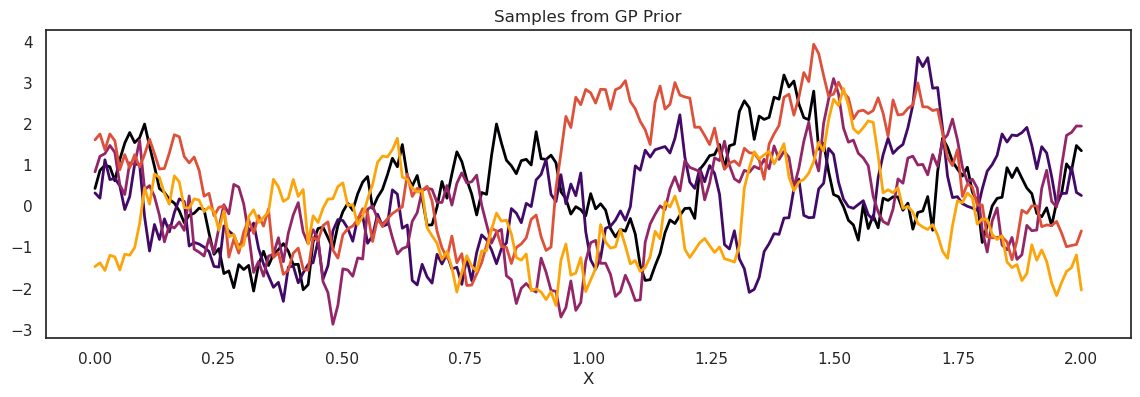

In [20]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern12(1, l)

K = pytensor.function([], cov(X_grid))()

plot_cov(X_grid, K)

### Cosine covariance

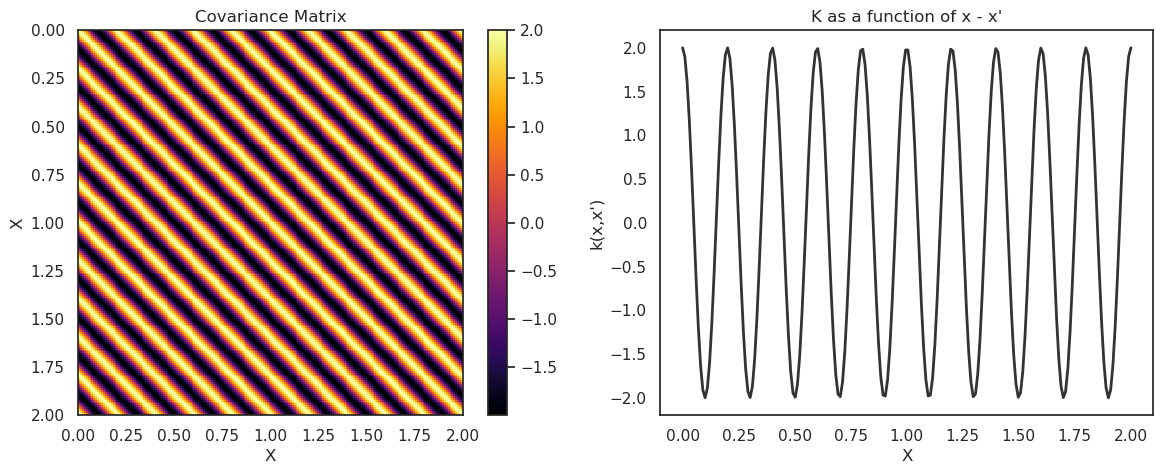

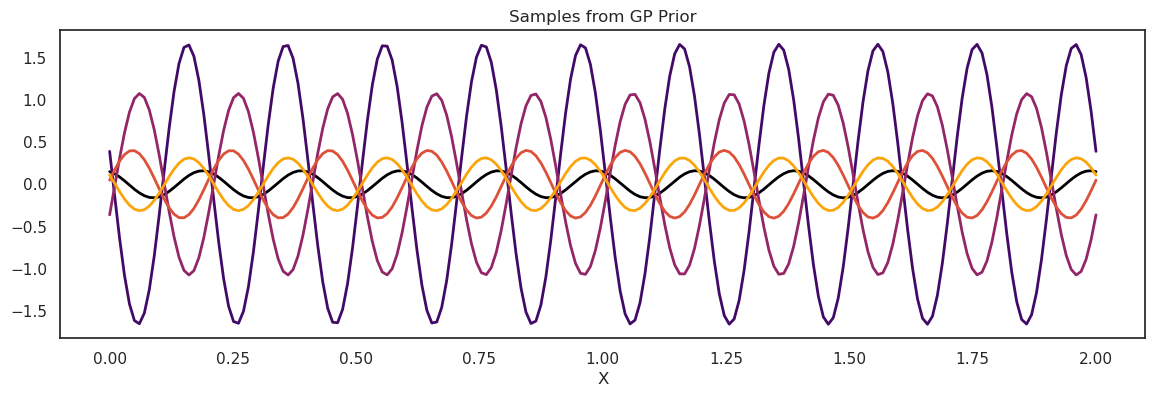

In [21]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = pytensor.function([], cov(X_grid))()

plot_cov(X_grid, K)

Now that we have a general idea about covariance functions, let's begin by defining one for our first model.

We can use a Matern(5/2) covariance to model our simulated data, and pass this as the `cov_func` argument to the `Marginal` class.

In [22]:
with pm.Model() as model:
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)

    cov = eta**2 * pm.gp.cov.Matern52(1, l)
    mean = pm.gp.mean.Constant(c=1)
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)

### The `.marginal_likelihood` method

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}|\mathbf{K}_{xx} + \boldsymbol\Sigma|
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.

In [23]:
X = x.reshape(-1, 1)

with model:
    sigma = pm.HalfCauchy("sigma", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, y=y, sigma=sigma)

In [24]:
with model:
    marginal_post = pm.sample(500, tune=2000, nuts_sampler="numpyro", chains=1)

sample: 100%|██████████| 2500/2500 [00:07<00:00, 340.80it/s, 7 steps of size 7.09e-01. acc. prob=0.87]
Only one chain was sampled, this makes it impossible to run some convergence checks


We can collect the results into a pandas dataframe to display

In [25]:
summary = az.summary(
    marginal_post, var_names=["l", "eta", "sigma"], round_to=2, kind="stats"
)
summary["True value"] = [l_true, eta_true, sigma_true]
summary

,mean,sd,hdi_3%,hdi_97%,True value
l,1.31,0.38,0.76,1.91,1.0
eta,5.14,2.23,2.21,8.61,3.0
sigma,1.95,0.15,1.66,2.22,2.0


### The `.conditional` distribution

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `conditional` method implements the predictive GP above, called with a grid of points over which to generate realizations:

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  

If using an additive GP model, the conditional distribution for individual components can be constructed by setting the optional argument `given`.  

We can define a grid of new values from `x=0` to `x=20`, then add the GP conditional to the model, given the new X values:



In [26]:
X_new = np.linspace(0, 20, 600)[:, None]

with model:
    f_pred = gp.conditional("f_pred", X_new)

We can draw samples from the posterior predictive distribution over the specified grid of values.

In [27]:
with model:
    pred_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 20)), var_names=["f_pred"]
    )

Sampling: [f_pred]


Output()

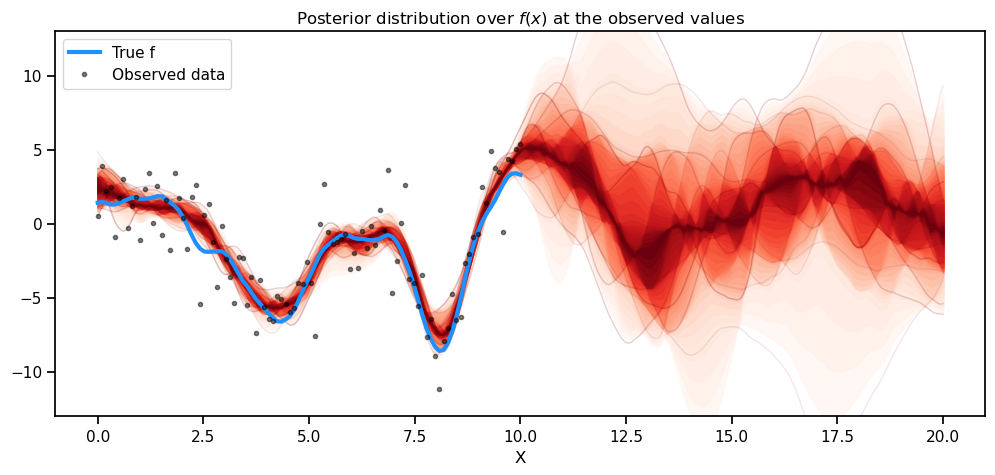

In [28]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_pred_samples = az.extract(
    pred_samples, group="posterior_predictive", var_names=["f_pred"]
)
plot_gp_dist(ax, samples=f_pred_samples.T, x=X_new)
# plot the data and the true latent function
plt.plot(x, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(x, y, "ok", ms=3, alpha=0.5, label="Observed data")
# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [29]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 20)), var_names=["y_pred"]
    )

Sampling: [y_pred]


Output()

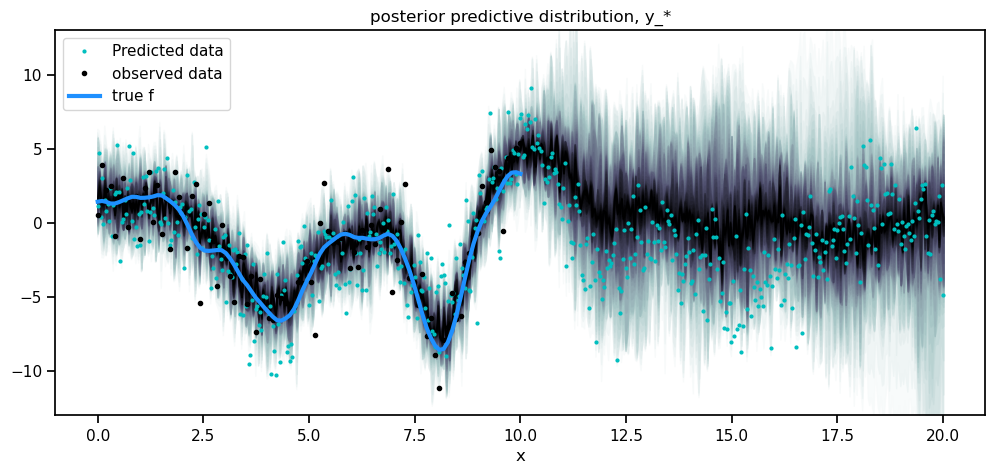

In [30]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# posterior predictive distribution
y_pred_samples = az.extract(
    y_samples, group="posterior_predictive", var_names=["y_pred"]
)
plot_gp_dist(ax, y_pred_samples.T, X_new, plot_samples=False, palette="bone_r")
# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, y_pred_samples.values.T[1], "co", ms=2, label="Predicted data")
# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")
plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("posterior predictive distribution, y_*")
plt.legend();

### Real-world example: Spawning salmon

That was contrived data; let's try applying Gaussian processes to a real problem. The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

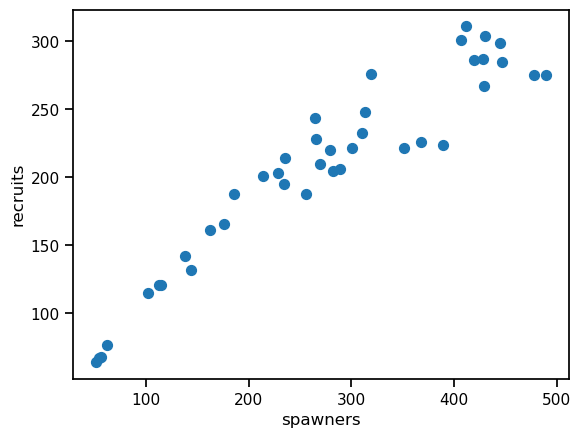

In [33]:
try:
    salmon_data = pd.read_table("../data/salmon.txt", sep=r"\s+", index_col=0)
except FileNotFoundError:
    salmon_data = pd.read_table(DATA_URL + "salmon.txt", sep=r"\s+", index_col=0)

salmon_data.plot.scatter(x="spawners", y="recruits", s=50);

In [34]:
with pm.Model() as salmon_model:
    # Lengthscale
    rho = pm.LogNormal("rho", 0, 1)
    eta = pm.LogNormal("eta", 0, 1)

    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits / salmon_data.spawners).mean())
    K = (eta**2) * pm.gp.cov.ExpQuad(1, rho)

    sigma = pm.HalfNormal("sigma", 5)

    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood(
        "recruits",
        X=salmon_data.spawners.values.reshape(-1, 1),
        y=salmon_data.recruits.values,
        sigma=sigma,
    )

/Users/alex_andorra/mambaforge/envs/gp-pydata24/lib/python3.12/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [35]:
with salmon_model:
    map_est = pm.find_MAP()
    print(map_est)

Output()

{'rho_log__': array(-0.99979598), 'eta_log__': array(-0.99447068), 'sigma_log__': array(3.56846898), 'rho': array(0.3679545), 'eta': array(0.3699192), 'sigma': array(35.46225799)}


In [36]:
with salmon_model:
    salmon_trace = pm.sample(1000, tune=2000, nuts_sampler="numpyro", chains=1)

sample: 100%|██████████| 3000/3000 [00:03<00:00, 953.74it/s, 3 steps of size 6.16e-01. acc. prob=0.89] 
Only one chain was sampled, this makes it impossible to run some convergence checks


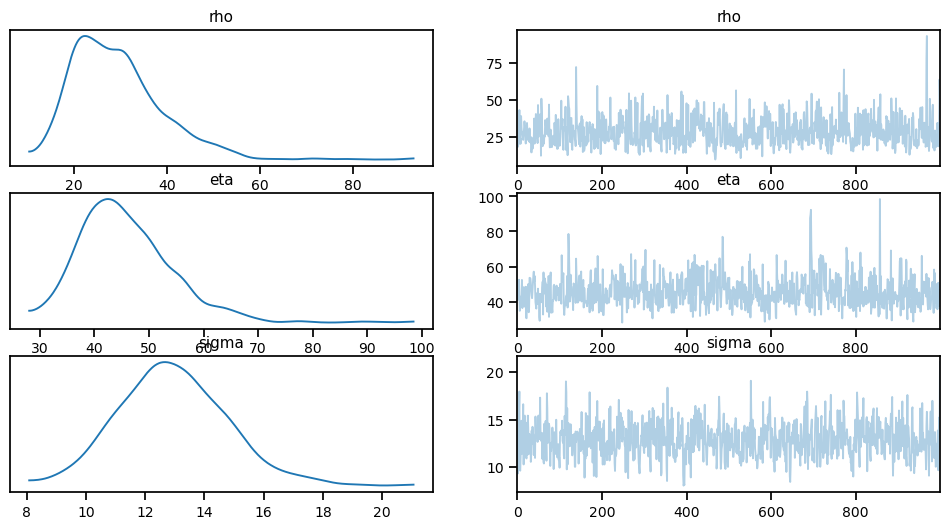

In [37]:
az.plot_trace(salmon_trace, var_names=["rho", "eta", "sigma"]);

In [38]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)
with salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred)
    salmon_samples = pm.sample_posterior_predictive(
        salmon_trace.sel(draw=slice(0, 5)), var_names=["salmon_pred"]
    )

Sampling: [salmon_pred]


Output()

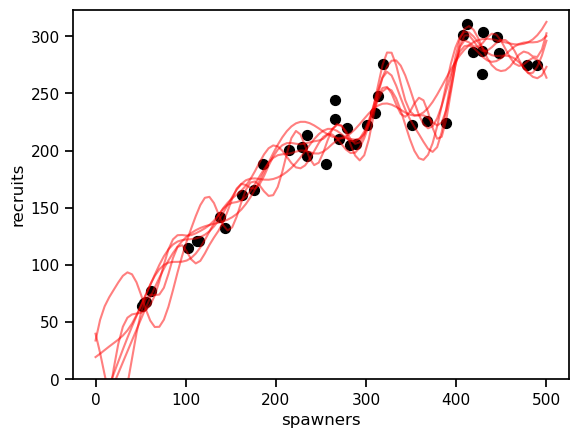

In [39]:
ax = salmon_data.plot.scatter(x="spawners", y="recruits", c="k", s=50)
ax.set_ylim(0, None)
for x in az.extract(salmon_samples.posterior_predictive)["salmon_pred"].values.T:
    ax.plot(X_pred, x, alpha=0.5, c="r")

### Using `.predict`

We can use the `.predict` method to return the mean and variance given a particular `point`.  Since we used `find_MAP` in this example, `predict` returns the same mean and covariance that the distribution of `.conditional` has.  

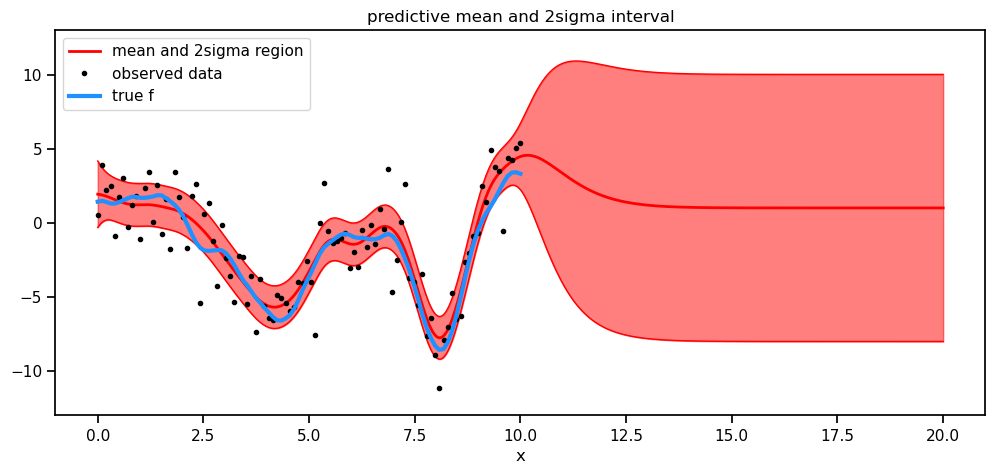

In [40]:
# predict
with model:
    mu, var = gp.predict(
        X_new,
        point=az.extract(marginal_post.posterior.sel(draw=[0])).squeeze(),
        diag=True,
    )
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2sigma intervals
plt.plot(X_new, mu, "r", lw=2, label="mean and 2sigma region")
plt.plot(X_new, mu + 2 * sd, "r", lw=1)
plt.plot(X_new, mu - 2 * sd, "r", lw=1)
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")
plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("predictive mean and 2sigma interval")
plt.legend();

## Latent Variable Implementation

The `gp.Latent` class is a more general implementation of a GP.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

## `.prior`

With some data set of finite size, the `prior` method places a multivariate normal prior distribution on the vector of function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  

By default, PyMC reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This helps to reduce covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## Robust regession

The following is an example showing how to specify a simple model with a GP prior using the `gp.Latent` class.  So we can verify that the inference we perform is correct, the data set is made using a draw from a GP.  This will be identical to the first example, except that the noise is Student-T distributed.

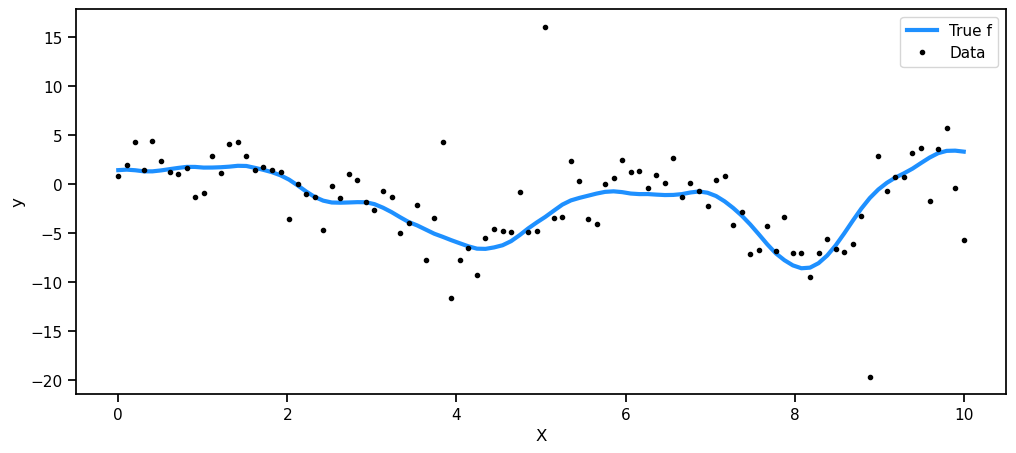

In [41]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[
    :, None
]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ls_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ls_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of PyTensor
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
sigma_true = 2.0
nu_true = 3.0
y = f_true + sigma_true * np.random.standard_t(nu_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

Here's the model in PyMC.  We use a $\text{Gamma}(2, 1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfCauchy}(2)$ priors over the covariance function scale, and noise scale.  A $\text{Gamma}(2, 0.1)$ prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  

In [42]:
with pm.Model() as model:
    ls = pm.Gamma("ls", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=2)

    cov = eta**2 * pm.gp.cov.Matern52(1, ls)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    sigma = pm.HalfCauchy("sigma", beta=2)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=y)

    trace = pm.sample(nuts_sampler="numpyro", chains=1)

sample: 100%|██████████| 2000/2000 [00:50<00:00, 39.86it/s, 63 steps of size 8.21e-02. acc. prob=0.87]
2024-11-22 17:44:24.160711: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.3 = f64[1,1000,100,100]{3,2,1,0} reduce(f64[1,1000,1,100,100]{4,3,2,1,0} %broadcast.8, f64[] %constant.25), dimensions={2}, to_apply=%region_1.98, metadata={op_name="jit(process_fn)/jit(main)/reduce_sum" source_file="/var/folders/m_/brf3tky55f3gf6dy8w7c6s0w0000gn/T/tmp5o_28hqt" source_line=51}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-22 17:44:42.169214: E external/xla/xla/service/slow

Below are the posteriors of the covariance function hyperparameters. 

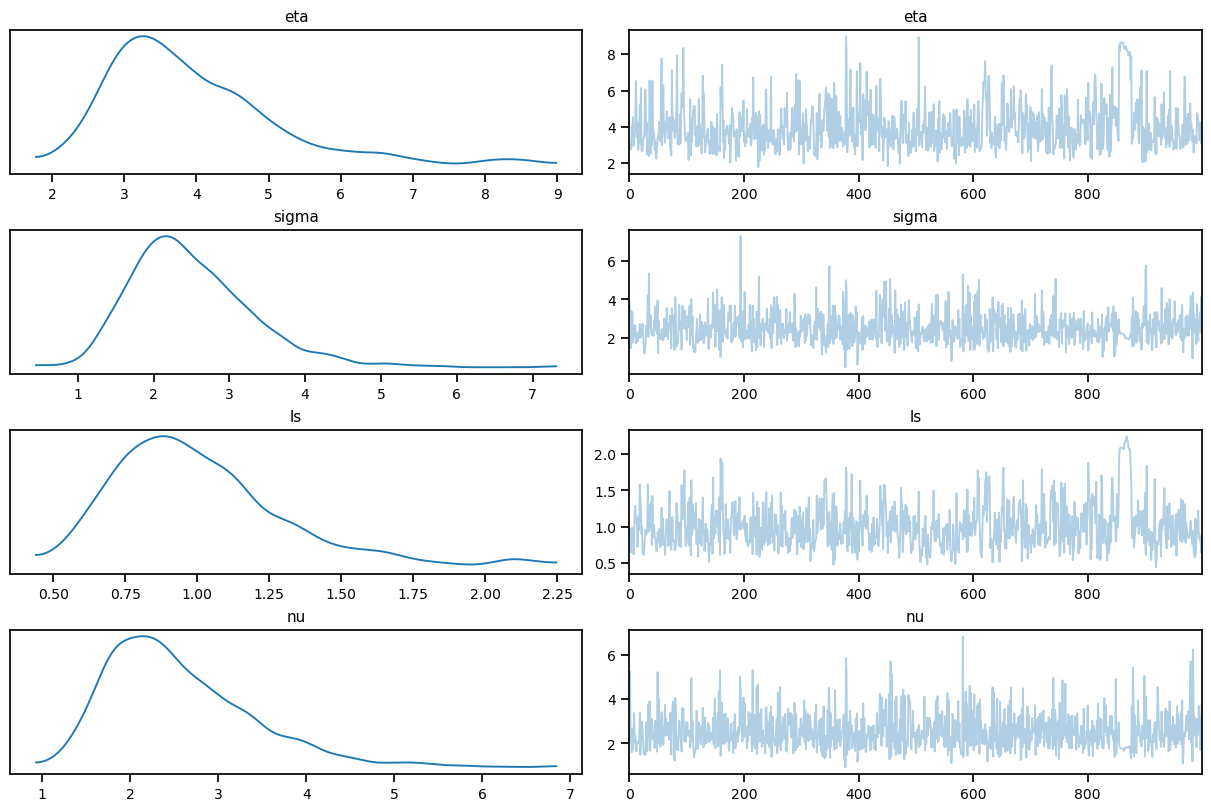

In [43]:
az.plot_trace(
    trace,
    var_names=["eta", "sigma", "ls", "nu"],
    backend_kwargs=dict(constrained_layout=True),
);

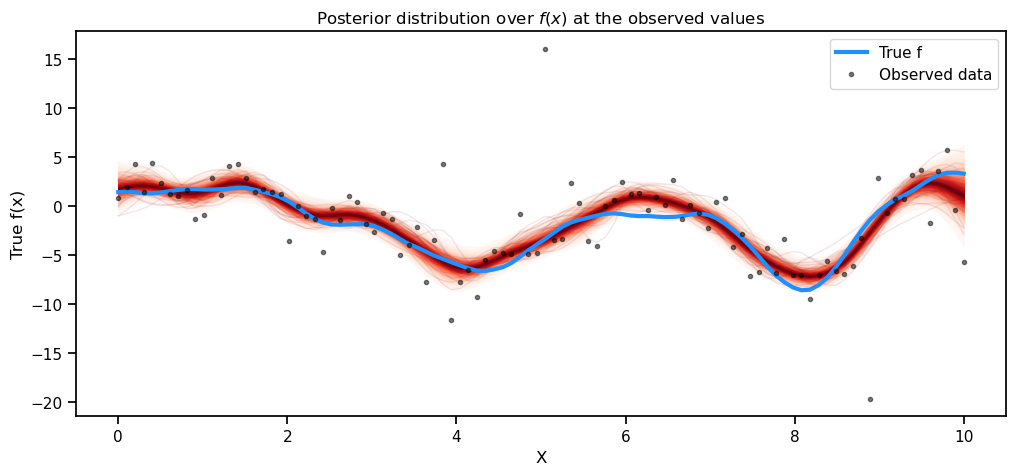

In [44]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"].values[0], X)
# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

### Exercise: Coal mining disasters

The number of coal mining disasters in the UK from 1851 to 1962 is thought to follow a Poisson process with a large rate parameter in the early years and a smaller rate in the later years. We previously modeled this data using a piecewise constant Poisson mean. Use the latent variable implementation to fit a GP to this data.

In [ ]:
disasters_array = np.array(
    [
        4,
        5,
        4,
        0,
        1,
        4,
        3,
        4,
        0,
        6,
        3,
        3,
        4,
        0,
        2,
        6,
        3,
        3,
        5,
        4,
        5,
        3,
        1,
        4,
        4,
        1,
        5,
        5,
        3,
        4,
        2,
        5,
        2,
        2,
        3,
        4,
        2,
        1,
        3,
        2,
        2,
        1,
        1,
        1,
        1,
        3,
        0,
        0,
        1,
        0,
        1,
        1,
        0,
        0,
        3,
        1,
        0,
        3,
        2,
        2,
        0,
        1,
        1,
        1,
        0,
        1,
        0,
        1,
        0,
        0,
        0,
        2,
        1,
        0,
        0,
        0,
        1,
        1,
        0,
        2,
        3,
        3,
        1,
        1,
        2,
        1,
        1,
        1,
        1,
        2,
        4,
        2,
        0,
        0,
        1,
        4,
        0,
        0,
        0,
        1,
        0,
        0,
        0,
        0,
        0,
        1,
        0,
        0,
        1,
        0,
        1,
    ]
)
years = np.arange(1851, 1962, dtype=int)

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(years, disasters_array, color="#348ABD", alpha=0.65, width=0.7)
ax.set_xlim(years[0], years[-1] + 1)
ax.set_ylabel("Disaster count")
ax.set_xlabel("Year");

In [59]:
# Write your answer here

## Faster Gaussian processes

One of the major constraints that limits the utility of Gaussian processes in practice is the inversion of $K$ when calculating the posterior covariance. Since it is evaluated at every observed data point, its execution time is $\mathcal{O(n^3)}$, which makes Gaussian processes (in the form I have presented here) impractical for larger datasets.

An approach for dealing with this computation complexity is to look for an approximation to accelerate training and prediction. For Gaussian processes, this can be accomplished by employing a **sparse approximation** to the Gram matrix that places $M<<N$ *inducing points* along the range of the input variables, and uses this to estimate the full covariance matrix for the observed points. 

The `gp.MarginalSparse` class implements sparse, or inducing point, GP approximations.  It works identically to `gp.Marginal`, except it additionally requires the locations of the inducing points (denoted `Xu`), and it accepts the argument `sigma` instead of `noise` because these sparse approximations assume white IID noise.

The downside of sparse approximations is that they reduce the expressiveness of the GP.  Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.  

A choice that needs to be made is where to place the inducing points.  One option is to use a subset of the inputs.  Another possibility is to use K-means.  The location of the inducing points can also be an unknown and optimized as part of the model.  These sparse approximations are useful for speeding up calculations when the density of data points is high and the lengthscales is larger than the separations between inducing points. 

### Dense dataset

For the following examples, we use the same data set as was used in the `gp.Marginal` example, but with more data points.

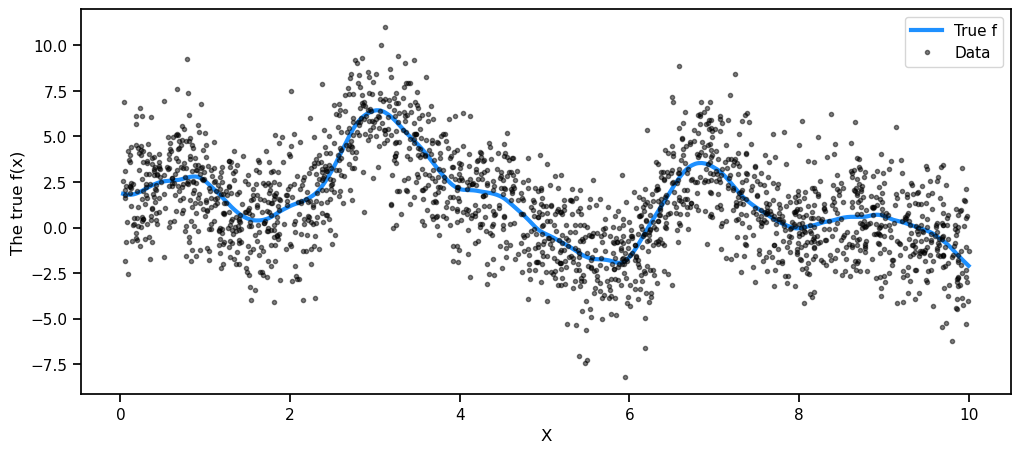

In [45]:
# set the seed
np.random.seed(42)

n = 2000  # The number of data points
X = 10 * np.sort(np.random.rand(n))[:, None]

# Define the true covariance function and its parameters
ls_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ls_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of PyTensor
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
sigma_true = 2.0
y = f_true + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

We can specify a sparse marginal likelihood model via `MarginalSparse`, where the approximation method can be chosen. We will use the **fully independent training conditional (FITC)** algorithm to estimate the model, with the critical approximation being the imposition of a conditional independence assumption on the joint prior over training and test cases.

In [46]:
with pm.Model() as sparse_model:
    ls = pm.Gamma("ls", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls)
    gp = pm.gp.MarginalApprox(cov_func=cov, approx="FITC")

We next need a set of inducing points. We will initialize 20 inducing points with the **K-means** algorithm.

In [47]:
with sparse_model:
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

From here, we use the `marginal_likelihood` method, just as we did with the full GP.

In [48]:
with sparse_model:
    sigma = pm.HalfCauchy("sigma", 5)
    obs = gp.marginal_likelihood("obs", X=X, Xu=Xu, y=y, sigma=sigma, jitter=1e-5)

    trace = pm.sample(nuts_sampler="numpyro", chains=1)

/Users/alex_andorra/mambaforge/envs/gp-pydata24/lib/python3.12/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
sample: 100%|██████████| 2000/2000 [00:16<00:00, 121.32it/s, 7 steps of size 5.34e-01. acc. prob=0.93] 
Only one chain was sampled, this makes it impossible to run some convergence checks


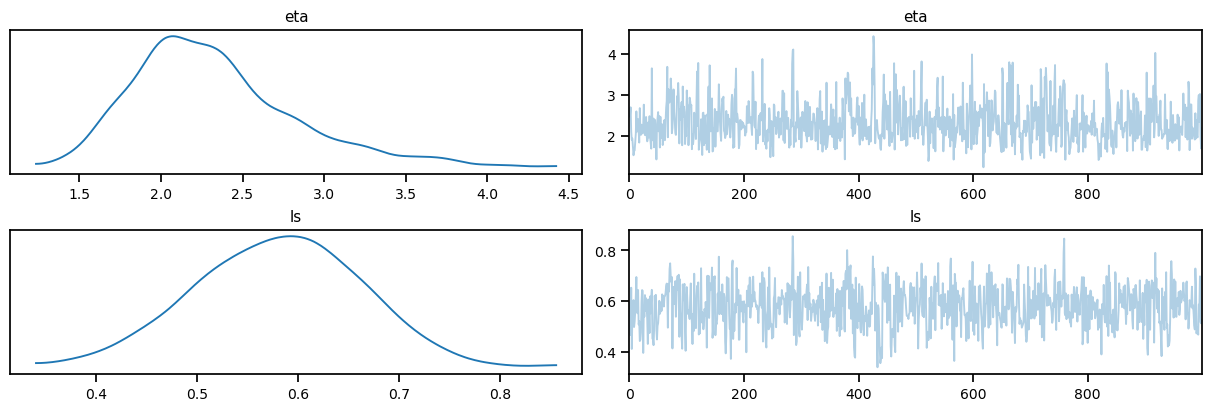

In [49]:
az.plot_trace(
    trace, var_names=["eta", "ls"], backend_kwargs=dict(constrained_layout=True)
);

In [50]:
X_new = np.linspace(-1, 11, 200)[:, None]

# add the GP conditional to the model, given the new X values
with sparse_model:
    f_pred = gp.conditional("f_pred", X_new)

In [51]:
with sparse_model:
    pred_samples = pm.sample_posterior_predictive(
        trace.sel(draw=slice(0, 5)), var_names=["f_pred"]
    )

/var/folders/m_/brf3tky55f3gf6dy8w7c6s0w0000gn/T/ipykernel_12642/4257160252.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pred_samples = pm.sample_posterior_predictive(
Sampling: [f_pred]


Output()

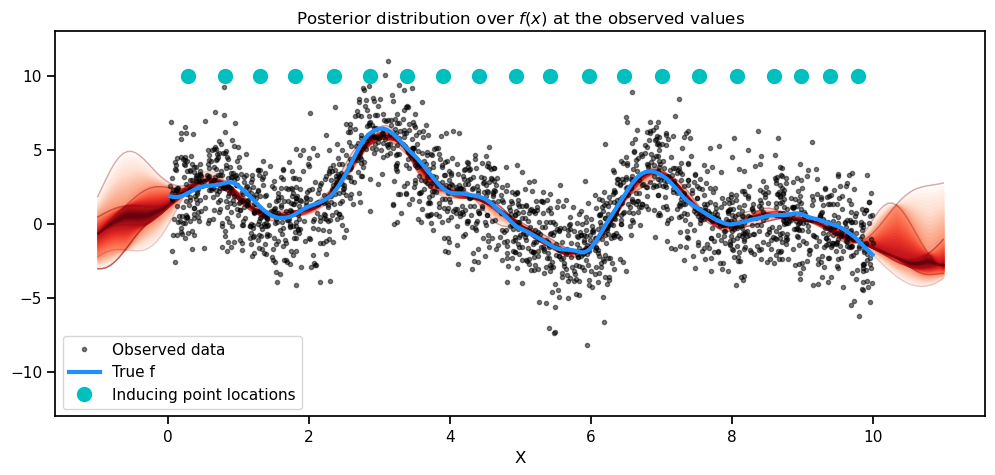

In [52]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_pred_samples = az.extract(
    pred_samples, group="posterior_predictive", var_names=["f_pred"]
)
plot_gp_dist(ax, f_pred_samples.T, X_new)
# plot the data and the true latent function
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(Xu, 10 * np.ones(Xu.shape[0]), "co", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

## Hilbert Space Approximate Gaussian Processes (HSGP)

The Hilbert Space Gaussian processes approximation is a **low-rank GP approximation** that is particularly well-suited to usage in probabilistic programming languages.  It approximates the GP using a pre-computed and fixed set of basis functions that don't depend on the form of the covariance kernel or its hyperparameters.  It's a _parametric_ approximation, so prediction can be done as one would with any other type of Bayesian model in PyMC;  You don't need to define the `.conditional` distribution that the `Marginal` and `Latent` GPs rely on.  This makes it _much_ easier to integrate an HSGP into your existing model as they can be used anywhere within a model and with any likelihood function.  

It's also fast! 🏃 The computational cost for standard GPs per MCMC step is $\mathcal{O}(n^3)$, where $n$ is the number of data points.  For HSGPs, it is $\mathcal{O}(mn + m)$, where $m$ is the number of basis vectors. 

The HSGP approximation does carry some caveats:
1. It can only be used with _stationary_ covariance kernels such as the Matern family.  The `HSGP` class is compatible with any `Covariance` class that implements the `power_spectral_density` method.  There is a special case made for the `Periodic` covariance, which is implemented in PyMC by `HSGPPeriodic`. 
2. It does not scale well with the input dimension.  The HSGP approximation is a good choice if your GP is over a one dimensional process like a time series, or a two dimensional spatial point process.  It's likely not an efficient choice where the input dimension is larger than three. 
3. It _may_ struggle with more rapidly varying processes.  If the process you're trying to model changes very quickly relative to the extent of the domain, the HSGP approximation may fail to accurately represent it.  We'll show in later sections how to set the accuracy of the approximation, which involves a trade-off between the fidelity of the approximation and the computational complexity.
4. For smaller data sets, the full unapproximated GP may still be more efficient.

A secondary goal of this implementation is **flexibility** via an accessible implementation where the core computations are implemented in a modular way. This results in both a "high-level" interface where users can use the familiar `.prior` and `.conditional` methods and essentially treat the HSGP class as a drop in replacement for `pm.gp.Latent`, and a "low-level" interface that exposes the HSGP as a parametric model.  For more complex models with multiple HSGPs, users can work directly with functions like `pm.gp.hsgp_approx.calc_eigenvalues` and `pm.gp.hsgp_approx.calc_eigenvectors`.

### How does it work?

In HSGP, the covariance function is viewed as a mathematical operator acting on a high-dimensional space (Hilbert space). We represent covariance function as a series expansion of eigenvalues and eigenfunctions of the Laplace operator. These eigenfunctions capture the smoothness properties of the underlying function being modeled in the form of a set of basis functions.

$$
f \sim \mathcal{G P}\left(0, k\left(x, x^{\prime} ; \ell\right)\right) \longrightarrow f \approx \phi(x) \beta(\ell)
$$

where the basis functions $\phi$ only depend on the input and the coefficients $\beta$ only depend on the kernel hyperparmeters.

By approximating the covariance function with a set of basis functions, HSGP reduces the complexity significantly, from $\mathcal{O}(n^3)$ to $\mathcal{O}(nm + m)$. 


## Cherry blossom dataset

The data for this example is the number of days (`doy` for "days of year") that the cherry trees were in bloom in each year (`year`). 
For convenience, years missing a `doy` were dropped (which is a bad idea to deal with missing data in general!).

In [53]:
try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [54]:
blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)
blossom_data.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


After dropping rows with missing data, there are 827 years with the numbers of days in which the trees were in bloom.

In [55]:
blossom_data.shape

(827, 5)

If we visualize the data, it is clear that there a lot of annual variation, but some evidence for a non-linear trend in bloom days over time.

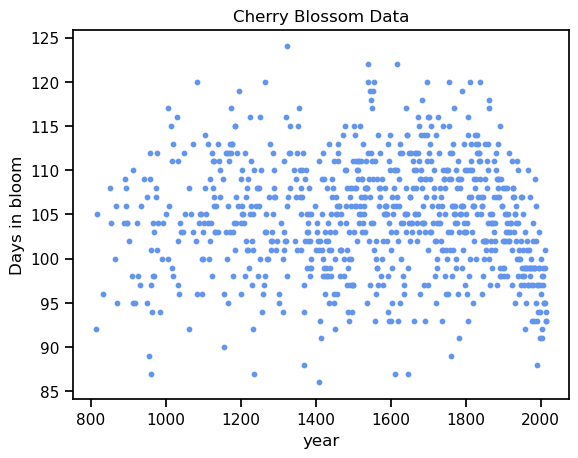

In [56]:
blossom_data.plot.scatter(
    "year",
    "doy",
    color="cornflowerblue",
    s=10,
    title="Cherry Blossom Data",
    ylabel="Days in bloom",
);

Let's focus on three columns: 
- `doy` the day of year of the first bloom
- `temp` the temperature (since it goes so far back in time, I'm not sure how it's reconstructed)
- `year` is of course the year

In [57]:
df = blossom_data[["year", "doy", "temp"]].dropna()

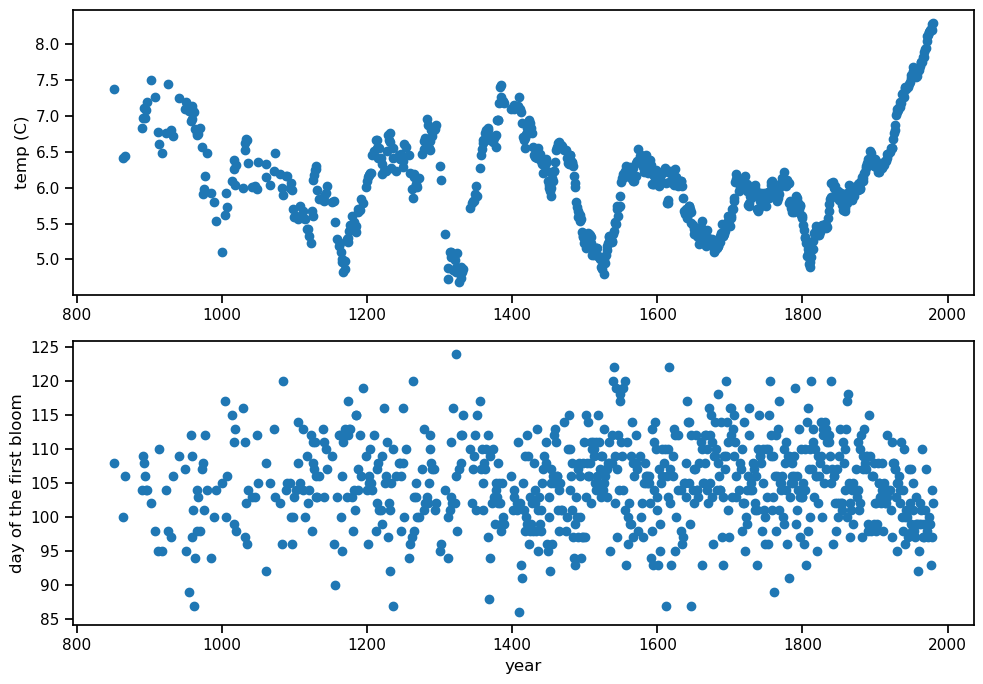

In [58]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs = axs.flatten()

axs[0].scatter(df["year"], df["temp"])
axs[1].scatter(df["year"], df["doy"])

axs[1].set_xlabel("year")
axs[0].set_ylabel("temp (C)")
axs[1].set_ylabel("day of the first bloom")
fig.tight_layout()

The first step is the same as with any other GP model: we need to specify a covariance function. We will use the Matern 5/2 covariance function, which is a good default choice for many problems.

(InverseGamma(alpha=7.34, beta=703), <Axes: >)

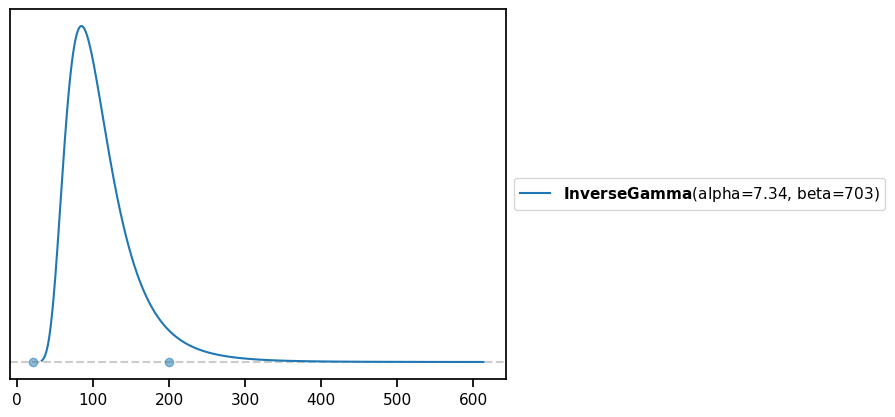

In [59]:
pz.maxent(pz.InverseGamma(), lower=20, upper=200, mass=0.95)

In [60]:
coords = {"year": df.year.tolist()}
with pm.Model(coords=coords) as cherry_blossom_model:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)

    ell = pz.maxent(
        pz.InverseGamma(), lower=20, upper=200, mass=0.95, plot=False
    ).to_pymc("ell")

    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)

The next step is to specify the HSGP model. We will use the `HSGP` class, which is a drop-in replacement for the `gp.Latent` class. 

There are three important hyperparameters for `HSGP`:

- `m`: The **number of basis vectors** to use for each active dimension.
- `L`: The **boundary of the space** for each active_dim. It is called the boundary condition. Choose `L` such that the domain `[-L, L]` contains all points in the column of `X` given by the active dimension.
- `c`: The **proportion extension factor**. Used to construct `L` from `X`. Defined as $S = \max|X| \ni X \in [-S, S]$. L is calculated as `c * S`. One of `c` or `L` must be provided. 

# Choosing the HSGP approximation parameters

Before fitting a model with an HSGP, you have to choose `m` and `c` or `L`.  `m` is the number of basis vectors.  Recall that the computational complexity of the HSGP approximation is $\mathcal{O}(mn + m)$, where $n$ is the number of data points. 

This choice is a balance between three concerns:
1.  The accuracy of the approximation.
2.  Reducing the computational burden.
3.  The `X` locations where predictions or forecasts will need to be made.

The best way to understand how to choose these parameters is to understand how `m`, `c` and `L` relate to each other, which requires understanding a bit more about how the approximation works under the hood.  

### How `L` and `c` affect the basis

The HSGP approximates the GP prior as a **linear combination of sinusoids**.  The coefficients of the linear combination are IID normal random variables whose standard deviation depends on GP hyperparameters (which are an amplitude and lengthscale for the Matern family). 

To see this, we'll make a few plots of the $m=3$ basis vectors and pay careful attention to how they behave at the boundaries of the domain.  Note that we have to center the `x` data first, and then choose `L` in relation to the centered data.  It's worth mentioning here that the basis vectors we're plotting do not depend on either the choice of the covariance kernel or on any unknown parameters the covariance function has.    

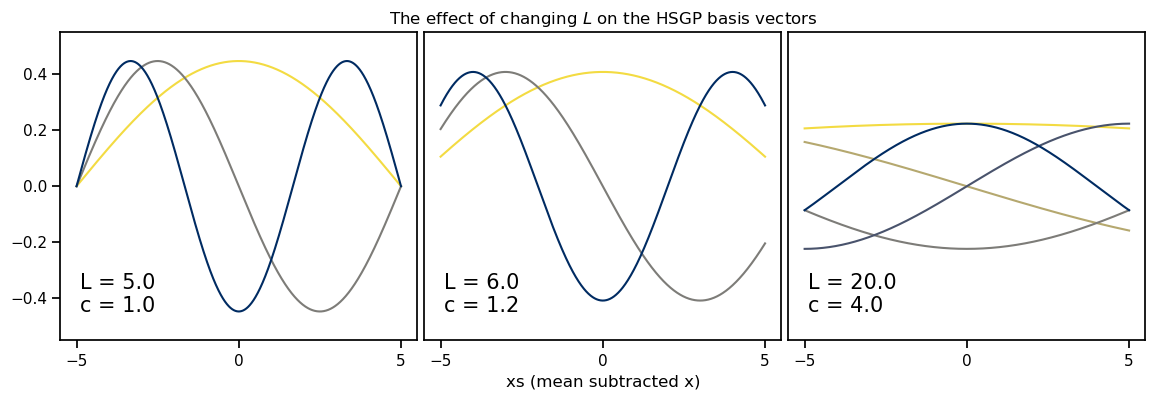

In [61]:
# Our data goes from x=-5 to x=5
x = np.linspace(-5, 5, 1000)

# (plotting code)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.02)
ylim = 0.55
axs[0].set_ylim([-ylim, ylim])
axs[1].set_yticks([])
axs[1].set_ylim([-ylim, ylim])
axs[1].set_xlabel("xs (mean subtracted x)")
axs[1].set_title("The effect of changing $L$ on the HSGP basis vectors")
axs[2].set_yticks([])
axs[2].set_ylim([-ylim, ylim])

# change L as we create the basis vectors
L_options = [5.0, 6.0, 20.0]
m_options = [3, 3, 5]
for i, ax in enumerate(axs.flatten()):
    L = L_options[i]
    m = m_options[i]

    eigvals = pm.gp.hsgp_approx.calc_eigenvalues(pt.as_tensor([L]), [m])
    phi = pm.gp.hsgp_approx.calc_eigenvectors(
        x[:, None], pt.as_tensor([L]), eigvals, [m]
    ).eval()

    colors = plt.cm.cividis_r(np.linspace(0.05, 0.95, m))
    for j in range(phi.shape[1]):
        ax.plot(x, phi[:, j], color=colors[j], label=f"eigenvector {j+1}")

    ax.set_xticks(np.arange(-5, 6, 5))

    S = 5.0
    c = L / S
    ax.text(-4.9, -0.45, f"L = {L}\nc = {c}", fontsize=15)

Notice that both `L` and `m` are specified as lists, to allow setting `L` and `m` per input dimension.  In this example these are both one element lists since our example is in a one dimensional, time series like context.  Before continuing, it's helpful to define $S$ as the half range of the centered data, or the distance from the midpoint at $x=0$ to the edge, $x=5$.  In this example $S=5$ for each plot panel.  Then, we can define $c$ such that it relates $S$ to $L$, 

$$
L = c \cdot S \,.
$$
It's usually easier to set $L$ by choosing $c$, which acts as a multiplier on $S$.  

In the left-most plot we chose $L=S=5$, which is exactly on the edge of our `x` locations.  For any $m$, all the basis vectors are forced to pinch to zero at the edges, at $x=-5$ and $x=5$.  This means that the HSGP approximation becomes poor as you get closer to $x=-5$ and $x=5$.  How quickly depends on the lengthscale.  Large lengthscales require larger values of $L$ and $c$, and smaller lengthscales attenuate this issue.  Ruitort-Mayol *et al.* recommend using 1.2 as a minimum value.  The effect of this choice on the basis vectors is shown in the center panel.  

The right panel shows the effect of choosing a larger $L$, or setting $c=4$.  Larger values of $L$ or $c$ make the boundary conditions less problematic, and are required to accurately approximate GPs with longer lengthscales.  You also need to consider where predictions will need to be made.  In addition to the locations of the observed $x$ values, the locations of the new $x$ locations also need to be away from the "pinch" caused by the boundary condition.  The _period_ of the basis functions also increases as we increase $L$ or $c$.  This means that we will need to increase $m$ in order to compensate if we wish to approximate GPs with smaller lengthscales.  

With large $L$ or $c$, the first eigenvector can flatten so much that it becomes partially or completely unidentifiable with the intercept in the model.  The right-most panel is an example of this.  It can be very beneficial to sampling to drop the first eigenvector in these situations.  The `HSGP` and `HSGPPeriodic` class in PyMC both have the option `drop_first` to do this, or if you're using `.prior_linearized` you can control this yourself.  Be sure to check the basis vectors if the sampler is having issues.

To summarize:

- Increasing $m$ helps the HSGP approximate GPs with smaller lengthscales, at the cost of increasing computational complexity
- Increasing $c$ or $L$ helps the HSGP approximate GPs with larger lengthscales, but may require increasing $m$ to compensate for the loss of fidelity at smaller lengthscales.  
- When choosing $m$, $c$ or $L$, it's important to consider the locations where you will need to make predictions, such that they also aren't affected by the boundary condition.
- The first eigenvector in the basis may be unidentified with the intercept, especially when $L$ or $c$ are larger. 


### Heuristics for choosing $m$ and $c$

In practice, you'll need to infer the lengthscale from the data, so the HSGP needs to approximate a GP across a range of lengthscales that are representative of your chosen prior.  You'll need to choose $c$ large enough to handle the largest lengthscales you might fit, and also choose $m$ large enough to accommodate the smallest lengthscales.  Ruitort-Mayol *et al.* give some handy heuristics for the range of lengthscales that are accurately reproduced for given values of $m$ and $c$.  The plot below uses their heuristics to recommend minimum $m$ and $c$ value.  Note that these recommendations are based on a one-dimensional GP.

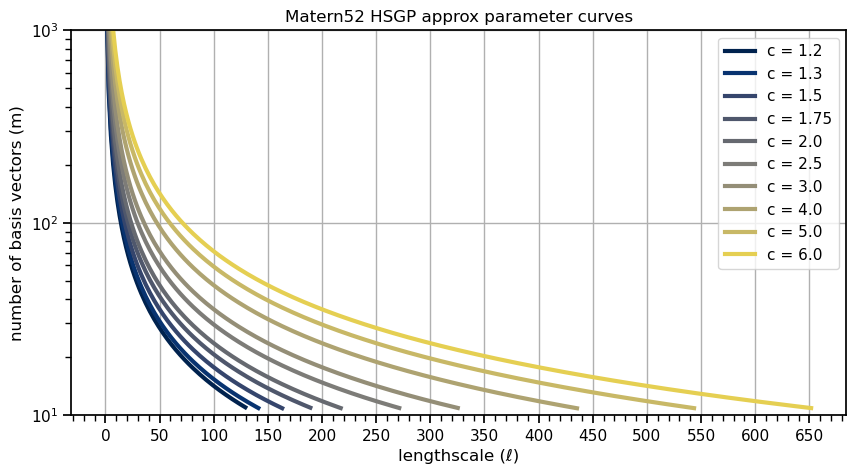

In [62]:
from matplotlib.ticker import MultipleLocator

c_list = np.array([1.2, 1.3, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0])
ell = np.linspace(1, 1000, 500)
S = (df["year"] - df["year"].mean()).max()  # half-range of the input data

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

cmap = plt.cm.cividis
colors = np.arange(len(c_list)) / len(c_list)

for i, c in enumerate(c_list):
    m = 2.65 * (c / ell) * S

    ix = c >= (4.1 * (ell / S))
    m[~ix] = np.nan
    ax.semilogy(ell, m, color=cmap(colors[i]), label="c = %s" % str(c), lw=3)

ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.set_title("Matern52 HSGP approx parameter curves")
ax.set_ylim([10, 1000])
ax.set_xlabel("lengthscale (ℓ)")
ax.set_ylabel("number of basis vectors (m)")
ax.legend();

The curves show the regions where the HSGP approximation is accurate.  For instance, the darkest blue line at $c=1.2$ means that if we choose $c=1.2$, our approximation will be valid for the smallest lengthscales up until about $\ell = 130$.  The yellow curve at $c=6.0$ means shows that the approximation is accurate up until about $\ell = 650$.  **How we choose these values depends on our prior for the lengthscale**.  In our case we are setting 95% of the prior mass between 20 and 200.  We'll be safe and choose $c=2$ and $m=400$ so our prior range is well covered pretty well.  

Also, keep in mind that HSGP scales as $\mathcal{O}(nm + m)$, so the smaller we can choose $m$, the better, speed-wise.  $c$ plays no role in computation speed.

### Using `HSGP` in PyMC

There are a couple of usage details that are important for using `HSGP` effectively. The first is that, due to how the basis vectors are constructed, the `HSGP` class requires that the `X` input data be centered.  This is because the basis vectors are constructed to be periodic over the range $[-L, L]$, and the center of the range is assumed to be zero.  

So, here we will center the age range on the mean age, taking care to use the closest integer value.

In [63]:
years = df["year"].values
years_centered = years - years[len(years) // 2]

In [64]:
with cherry_blossom_model:
    gp = pm.gp.HSGP(m=[400], c=2.0, cov_func=cov, parametrization="non-centered")
    f = gp.prior("f", X=years_centered[:, None], dims="year")

    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    mu = pm.Deterministic("mu", intercept + f, dims="year")

    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["temp"].values)

Notice that in the specification of `HSGP` the parameterization was set to **non-centered**. This relates to how the power spectrum is entered into the model. Here is what happens under the hood:

First, `prior_linearized` returns the eigenvector basis, `phi`, and the square root of the power spectrum at the eigenvalues, `sqrt_psd`.  You have to construct the HSGP approximation from these.  The following are the relevant lines of code, showing both the centered and non-centered parameterization.

```python
phi, sqrt_psd = gp.prior_linearized(Xs=Xs)

## non-centered
beta = pm.Normal("beta", size=gp._m_star)
f = pm.Deterministic("f", phi @ (beta * sqrt_psd)) 

## centered
beta = pm.Normal("beta", sigma=sqrt_psd, size=gp._m_star)
f = pm.Deterministic("f", phi @ beta) 
```

Choosing a non-centered parameterization may help alleviate sampling issues, but is not always necessary, particularlty if there are plenty of data informing the GP.

In [65]:
with cherry_blossom_model:
    trace_gp = pm.sample(nuts_sampler="numpyro", chains=2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


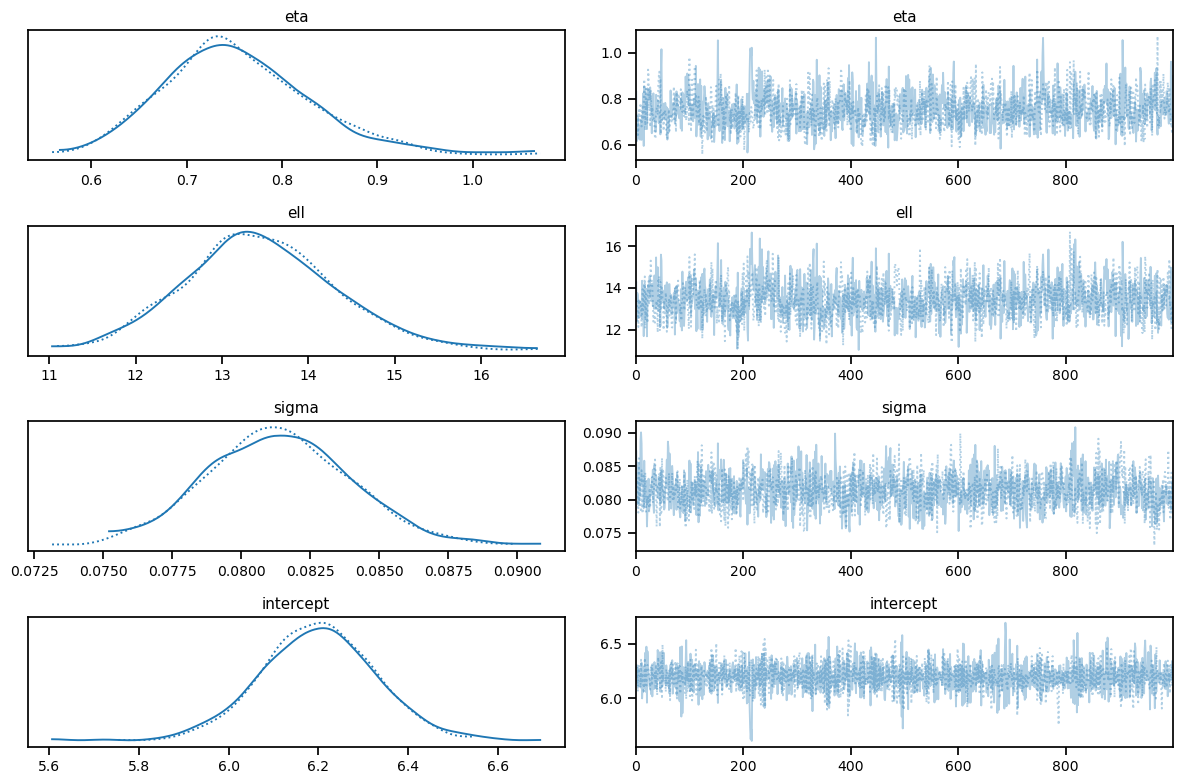

In [66]:
az.plot_trace(trace_gp, var_names=["eta", "ell", "sigma", "intercept"])
plt.tight_layout();

This took a few minutes on my machine. We see a lengthscale of about 40, which we can interpret as meaning that it takes about 40 years for significant changes in temperature to occur.  We can also interpret this to roughly mean that the GP is comfortable predicting out about 40 years.  

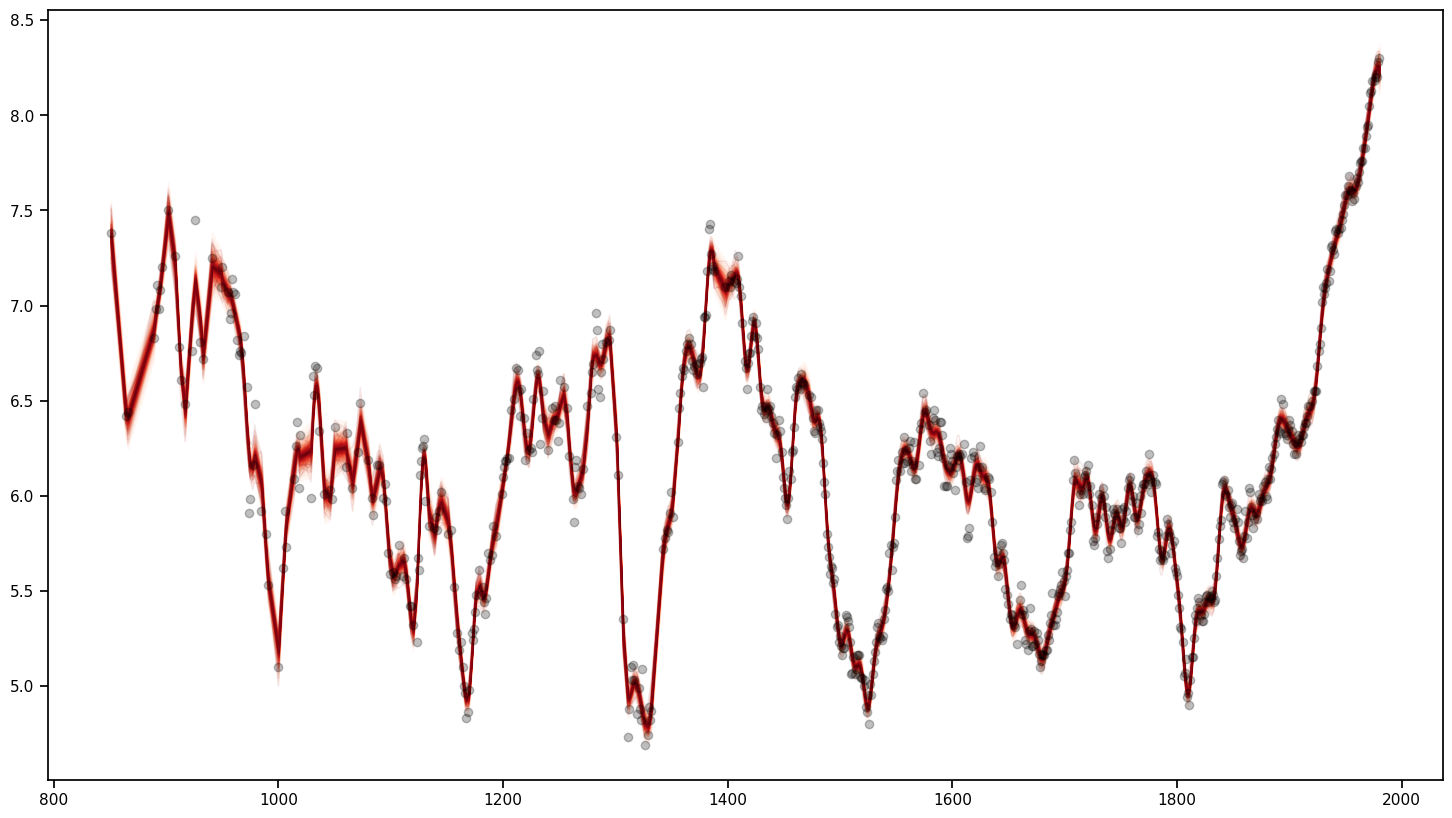

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
f = az.extract(trace_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=f.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

The HSGP approximation does carry some restrictions:
1. It **can only be used with _stationary_ covariance kernels** such as the Matern family.  The `HSGP` class is compatible with any `Covariance` class that implements the `power_spectral_density` method.  There is a special case made for the `Periodic` covariance, which is implemented in PyMC by The `HSGPPeriodic`.
2. It **does not scale well with the input dimension**.  The HSGP approximation is a good choice if your GP is over a one dimensional process like a time series, or a two dimensional spatial point process.  It's likely not an efficient choice where the input dimension is larger than three. 
3. It **_may_ struggle with more rapidly varying processes**.  If the process you're trying to model changes very quickly relative to the extent of the domain, the HSGP approximation may fail to accurately represent it.  
4. **For smaller data sets, the full unapproximated GP may still be more efficient**.

---
## References

[Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)

[Quinonero-Candela, J. & Rasmussen, C. E. (2005). A Unifying View of Sparse Approximate Gaussian Process Regression
Journal of Machine Learning Research 6, 1939–1959.](http://www.jmlr.org/papers/v6/quinonero-candela05a.html)



In [68]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Nov 22 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

scipy     : 1.12.0
matplotlib: 3.9.2
pytensor  : 2.25.5
pymc      : 5.17.0
arviz     : 0.20.0
pandas    : 2.2.3
preliz    : 0.11.0
numpy     : 1.26.4
seaborn   : 0.13.2

Watermark: 2.5.0

